# Build training sets
**!!! We strongly recommend using our Docker image for the setup of Jupyter backend.** 
**!!! If you choose not to use the Docker image, you'll need to install Slurm on your local machine, which can be tricky.** 
**!!! If you don't want to install the Slurm workload manager, you'll need to modify the code in utils.py, replacing 'qsub 0_run.pbs' with 'python 0_run.py' inside the splitRun function. Additionally, please ensure that the number of threads does not exceed the number of CPU threads on your computer. Exceeding this limit may lead to resource contention issues.**
**!!! 优先使用我们提供的Docker镜像运行Jupyter后端.** 
**!!! 如果您不想使用Docker镜像，则需要在本机上安装Slurm任务管理系统，这可能会比较复杂。请注意，在运行Jupyter后端之前，需要完成Slurm的安装,否则计算会报错.** 
**!!! 如果您不想安装Slurm任务管理系统，那么需要修改utils.py的代码，在splitRun函数内部替换 qsub 0_run.pbs为 python 0_run.py，并且确认线程数不会超过电脑的cpu线程数量，否则会出现计算资源挤占的问题.** 
https://github.com/xiaohang007/SLICES?tab=readme-ov-file#jupyter-backend-setup

In [2]:
%matplotlib inline
from slices.utils import temporaryWorkingDirectory,splitRun,show_progress,collect_json,collect_csv,adaptive_dynamic_binning
import os
import pandas as pd
import json
import pandas as pd
import numpy as np

if __name__ == "__main__":
    with temporaryWorkingDirectory("./data/mp20_nonmetal/"):
        output=[]
        data_path_predix="../mp20/"
        data=pd.read_csv(data_path_predix+"test.csv")
        cifs=list(data["cif"])
        ids=list(data["material_id"])
        eform=list(data["formation_energy_per_atom"])
        bandgap=list(data["band_gap"])
        for i in range(len(ids)):
            output.append({"material_id":ids[i],"formation_energy_per_atom":eform[i],"cif":cifs[i],"band_gap":bandgap[i]})
        data=pd.read_csv(data_path_predix+"val.csv")
        cifs=list(data["cif"])
        ids=list(data["material_id"])
        eform=list(data["formation_energy_per_atom"])
        bandgap=list(data["band_gap"])
        for i in range(len(ids)):
            output.append({"material_id":ids[i],"formation_energy_per_atom":eform[i],"cif":cifs[i],"band_gap":bandgap[i]})
        data=pd.read_csv(data_path_predix+"train.csv")
        cifs=list(data["cif"])
        ids=list(data["material_id"])
        eform=list(data["formation_energy_per_atom"])
        bandgap=list(data["band_gap"])
        for i in range(len(ids)):
            output.append({"material_id":ids[i],"formation_energy_per_atom":eform[i],"cif":cifs[i],"band_gap":bandgap[i]})
        with open('cifs.json', 'w') as f:
            json.dump(output, f)
        splitRun(filename='./cifs.json',threads=16,skip_header=False)
        show_progress()
        collect_json(output="cifs_filtered.json", \
            glob_target="./**/output.json",cleanup=False)
        collect_csv(output="mp20_eform_bandgap_nonmetal.csv", \
            glob_target="./**/result.csv",cleanup=True,header="SLICES,eform,bandgap\n")
        os.system("rm cifs.json")
        # 读取数据
        data = pd.read_csv('mp20_eform_bandgap_nonmetal.csv')
        target_column = data.columns[-1]  # 假设最后一列是目标值
        
        # 进行自适应动态分箱
        train_data, test_data, bins = adaptive_dynamic_binning(data, target_column)
        
        # 检查分布
        print("\n训练集分布:")
        print(train_data[target_column].value_counts(bins=bins, normalize=True).sort_index())
        print("\n测试集分布:")
        print(test_data[target_column].value_counts(bins=bins, normalize=True).sort_index())
        
        # 保存分割后的数据
        train_data.to_csv('train_data_reduce_zero.csv', index=False)
        test_data.to_csv('test_data_reduce_zero.csv', index=False)

Computational tasks have been submitted.


     100%|███████████████| 100/100 [04:33<00:00,  2.73s/it]   


Results have been collected into: cifs_filtered.json
Results have been collected into: mp20_eform_bandgap_nonmetal.csv

原始数据行数: 14681
清理后数据行数: 14681
自动确定的bin数量: 63

训练集分布:
(0.0093, 0.0403]    0.015956
(0.0403, 0.0746]    0.015870
(0.0746, 0.121]     0.015870
(0.121, 0.176]      0.015870
(0.176, 0.226]      0.015870
                      ...   
(4.673, 4.935]      0.015870
(4.935, 5.202]      0.015870
(5.202, 5.62]       0.015870
(5.62, 6.452]       0.015870
(6.452, 17.902]     0.015956
Name: proportion, Length: 63, dtype: float64

测试集分布:
(0.0093, 0.0403]    0.015873
(0.0403, 0.0746]    0.015873
(0.0746, 0.121]     0.015873
(0.121, 0.176]      0.015873
(0.176, 0.226]      0.015873
                      ...   
(4.673, 4.935]      0.015873
(4.935, 5.202]      0.015873
(5.202, 5.62]       0.015873
(5.62, 6.452]       0.015873
(6.452, 17.902]     0.015873
Name: proportion, Length: 63, dtype: float64


# Train MatterGPT for Single-Property Material Inverse Design (using formation energy as an example)
<span style="color:red">**CUDA in xiaohang07/slices Docker works on WSL@Windows 11 but may fail on Ubuntu; for Ubuntu, use host machine to train and generate SLICES with CrystalGPT.**</span>

**Set --epochs 5 to speed up the test run.**

**To accelerate the training process, consider adjusting the batch_size appropriately.**

In [1]:
from slices.utils import temporaryWorkingDirectory
import os
with temporaryWorkingDirectory("./MatterGPT/eform/1_train_generate"):
    os.system('''
    /bin/bash -c "source /opt/conda/etc/profile.d/conda.sh && conda activate chgnet && \
    python train.py --run_name bandgap_Aug1 --batch_size 12 --num_props 1 --max_epochs 5 --n_embd 768  --n_layer 12 --n_head 12 --learning_rate 3.3e-4 \
    --train_dataset '../../../data/mp20_nonmetal/train_data_reduce_zero.csv' --test_dataset '../../../data/mp20_nonmetal/test_data_reduce_zero.csv' "
    ''')

Co Co Co Co As As As As S S S S 0 9 ooo 0 6 ooo 0 4 ooo 0 8 ooo 0 11 oo- 0 5 ooo 1 4 ooo 1 10 ooo 1 6 o+o 1 11 ooo 1 7 o+o 1 8 o++ 2 5 --o 2 8 -oo 2 7 -oo 2 10 o-- 2 4 o-o 2 9 ooo 3 7 -oo 3 5 -oo 3 11 -oo 3 6 ooo 3 9 oo+ 3 10 ooo 4 8 o+o 5 9 +oo 6 11 ooo 7 10 +-o 
-0.6162958260416668
Constructing vocabulary...
Max length of slices:  392
Number of characters: 130
vocab_size: 132

['+++', '++-', '++o', '+-+', '+--', '+-o', '+o+', '+o-', '+oo', '-++', '-+-', '-+o', '--+', '---', '--o', '-o+', '-o-', '-oo', '0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9', '<', '>', 'Ag', 'Al', 'Ar', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca', 'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F', 'Fe', 'Ga', 'Gd', 'Ge', 'H', 'He', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir', 'K', 'Kr', 'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ne', 'Ni', 'O', 'Os', 'P', 'Pb', 'Pd', 'Pm', 'Pr', 'Pt', 'Rb', 'Re', 'Rh', 'Ru', 'S', 'Sb', 'Sc

epoch 1 iter 976: train loss 0.29645. lr 3.032845e-04: 100%|██████████| 977/977 [04:48<00:00,  3.39it/s]


test loss: 0.43494602301825397 

Saving at epoch 1 with best test loss: 0.43494602301825397


epoch 2 iter 976: train loss 0.37324. lr 2.219852e-04: 100%|██████████| 977/977 [04:47<00:00,  3.40it/s]


test loss: 0.3805821663454959 

Saving at epoch 2 with best test loss: 0.3805821663454959


epoch 3 iter 976: train loss 0.32620. lr 1.180529e-04: 100%|██████████| 977/977 [04:47<00:00,  3.40it/s]


test loss: 0.3421307621214554 

Saving at epoch 3 with best test loss: 0.3421307621214554


epoch 4 iter 976: train loss 0.47336. lr 3.300000e-05: 100%|██████████| 977/977 [04:48<00:00,  3.39it/s]


test loss: 0.3172908410852255 

Saving at epoch 4 with best test loss: 0.3172908410852255


epoch 5 iter 976: train loss 0.27970. lr 3.300000e-05: 100%|██████████| 977/977 [04:47<00:00,  3.39it/s]


test loss: 0.3102713422736658 

Saving at epoch 5 with best test loss: 0.3102713422736658


# Generate SLICES strings with specified $E_{form}$ = [-1,-2,-3,-4]  eV/atom
<span style="color:red">**CUDA in xiaohang07/slices Docker works on WSL@Windows 11 but may fail on Ubuntu; for Ubuntu, use host machine to train and generate SLICES with CrystalGPT.**</span>

**Set --gen_size 5 to speed up the test run.**

**To accelerate the generation process, consider adjusting the batch_size appropriately.**

In [2]:
from slices.utils import temporaryWorkingDirectory
import os
with temporaryWorkingDirectory("./MatterGPT/eform/1_train_generate"):
    os.system('''
    /bin/bash -c "source /opt/conda/etc/profile.d/conda.sh && conda activate chgnet && \
    python generate.py --model_weight bandgap_Aug1.pt --prop_targets '[-1.0, -2.0,-3,-4]' --gen_size 30 --batch_size 2 --csv_name inverse_designed_SLICES --n_head 12"
    ''')

Target 1 is : eform-1.0 eV/atom.
Target 2 is : eform-2.0 eV/atom.
Target 3 is : eform-3.0 eV/atom.
Target 4 is : eform-4.0 eV/atom.
./Voc_prior
Loading model
Model loaded


100%|██████████| 15/15 [01:39<00:00,  6.62s/it]


Total generated SLICES: 114
Unique canonical SLICES: 114
Valid ratio: 0.95
Unique ratio: 1.0


# Reconstruct crystals from SLICES, assess novelty, predict formation energy (CHGNet), and visualize

Computational tasks have been submitted.


     100%|███████████████| 100/100 [04:55<00:00,  2.95s/it]  


Results have been collected into: results.csv


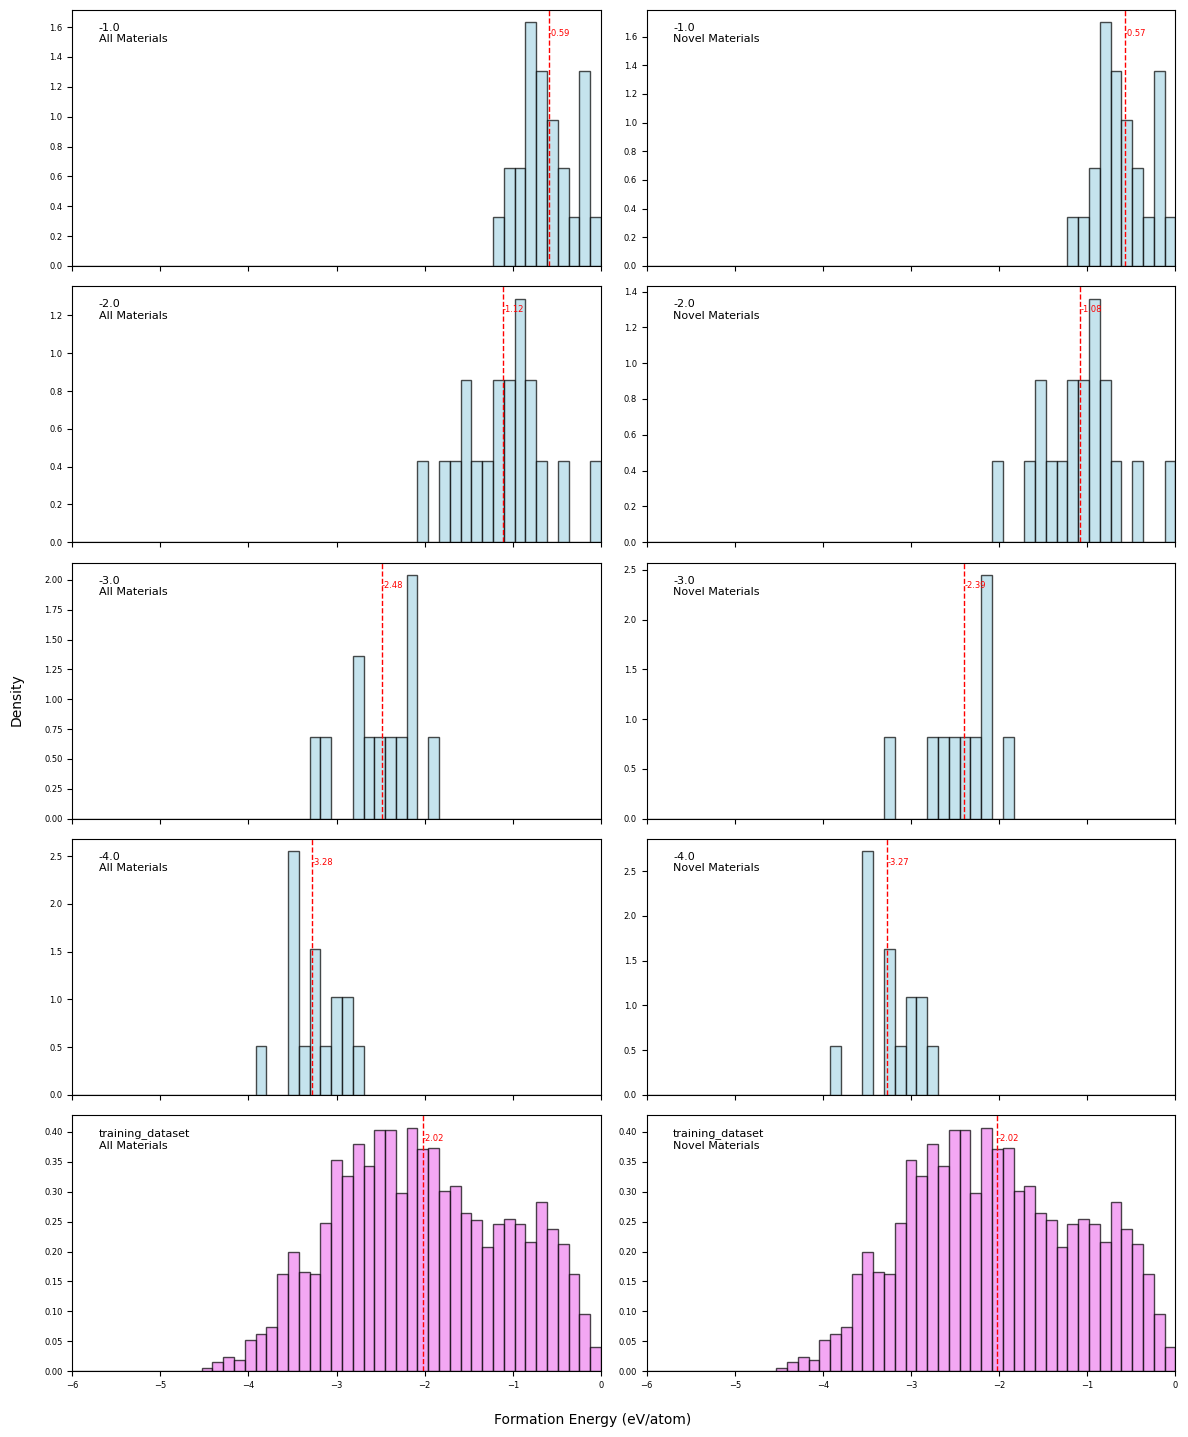

In [7]:
from slices.utils import temporaryWorkingDirectory,splitRun_csv,show_progress,collect_csv
import os
import glob
from slices.utils import splitRun_csv, show_progress, collect_csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import matplotlib.ticker as ticker
import pickle,json
from pymatgen.core.structure import Structure
train_dataset_json='../../../data/mp20_nonmetal/cifs_filtered.json'
train_dataset_csv="../../../data/mp20_nonmetal/train_data_reduce_zero.csv"
def load_and_save_structure_database():
    # json file (including "cif") of training dataset for novelty check
    with open(train_dataset_json, 'r') as f:
        cifs = json.load(f)
    structure_database = []
    for i in range(len(cifs)):
        cif_string = cifs[i]["cif"]
        try:
            stru = Structure.from_str(cif_string, "cif")
            structure_database.append([stru, cifs[i]["band_gap"]])
        except Exception as e:
            print(e)
    with open('structure_database.pkl', 'wb') as f:
        pickle.dump(structure_database, f)
def process_data():
    load_and_save_structure_database()
    splitRun_csv(filename='../1_train_generate/inverse_designed_SLICES.csv', threads=16, skip_header=True)
    show_progress()
    collect_csv(output="results.csv",
                glob_target="./job_*/result.csv", cleanup=True,
                header="eform_target,SLICES,eform_chgnet,poscar,novelty\n")
def prepare_data(results_file, training_file):
    results_1 = pd.read_csv(results_file)
    trainingset = pd.read_csv(training_file, header=0)
    
    header_values = results_1.iloc[:, 0].tolist()
    data_values = results_1.iloc[:, 2].tolist()
    trainingset_values = trainingset.iloc[:, 1].tolist()
    novelty_values = results_1.iloc[:, 4].tolist()
    data_dict = {}
    for header, value, novelty in zip(header_values, data_values, novelty_values):
        if header not in data_dict:
            data_dict[header] = {'all': [], 'novel': []}
        data_dict[header]['all'].append(value)
        if novelty == 1:
            data_dict[header]['novel'].append(value)
    sorted_keys = sorted(data_dict.keys(), reverse=True)
    return data_dict, sorted_keys, trainingset_values
def create_dataframe(data_dict, sorted_keys, trainingset_values, type='all'):
    df = pd.DataFrame({k: pd.Series(data_dict[k][type], index=range(len(data_dict[k][type]))) for k in sorted_keys})
    df = pd.concat([df, pd.Series(trainingset_values, name='training_dataset')], axis=1)
    return df
def plot_combined_histograms(all_data, novel_data, output_file):
    num_cols = len(all_data.columns)
    fig, axs = plt.subplots(num_cols, 2, figsize=(12, 3*num_cols), sharex=True)
    bins = np.linspace(-6, 0, 50)
    # Ensure axs is always 2D
    if num_cols == 1:
        axs = axs.reshape(1, -1)
    for i, col_name in enumerate(all_data.columns):
        for j, (data, title) in enumerate(zip([all_data, novel_data], ['All Materials', 'Novel Materials'])):
            color = 'violet' if col_name == 'training_dataset' else 'lightblue'
            axs[i, j].hist(data[col_name].dropna(), bins=bins, density=True, color=color, edgecolor='black', alpha=0.7)
            mu, std = norm.fit(data[col_name].dropna())
            axs[i, j].text(0.05, 0.95, f"{col_name}\n{title}", transform=axs[i, j].transAxes, fontsize=8, va='top')
            mean_val = data[col_name].mean()
            axs[i, j].axvline(mean_val, color='red', linestyle='--', linewidth=1)
            axs[i, j].text(mean_val, axs[i, j].get_ylim()[1]*0.9, f"{mean_val:.2f}", color='red', fontsize=6, ha='left')
    for ax in axs.flat:
        ax.set_xlim(-6, 0)
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.text(0.5, 0.02, 'Formation Energy (eV/atom)', ha='center', va='center', fontsize=10)
    fig.text(0.02, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=10)
    plt.subplots_adjust(hspace=0, wspace=0.1)
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    return fig
if __name__ == "__main__":
    with temporaryWorkingDirectory("./MatterGPT/eform/2_inverse_eform_novelty"):
        process_data()
        data_dict, sorted_keys, trainingset_values = prepare_data("results.csv", train_dataset_csv)
        # Process all materials
        all_materials_df = create_dataframe(data_dict, sorted_keys, trainingset_values, 'all')
        # Process novel materials
        novel_materials_df = create_dataframe(data_dict, sorted_keys, trainingset_values, 'novel')
        # Create and save the combined plot
        fig = plot_combined_histograms(all_materials_df, novel_materials_df, "combined_results.png")
        # Display the plot in Jupyter
        display(fig)
        plt.close(fig)

# Evaluate the formation energy distribution of the reconstructed crystals at PBE level (need workstation or even HPC to run VASP fastly)

In [ ]:
```bash
cd ./MatterGPT/eform/3_eform_DFT
python 1_run.py
# done
```